# 1. Install dependencies and libraries


In [111]:
import os
import numpy as np
from skimage import io
from scipy import signal
from math import sqrt
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import skimage.filters as skfl
from statistics import mean
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


import skimage.transform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import pandas as pd

# 2. Load Images
## 2.1. Load image directories into numpy arrays

In [112]:
dict_img = {}
for root, _, files in os.walk("textures\\training", topdown=False):
#     print(root[18:])
    dict_img[root[18:]] = np.array([root+ '\\' + i for i in files])

In [113]:
canvas1 = dict_img.get('canvas1')
cushion1 = dict_img.get('cushion1')
linsseeds1 = dict_img.get('linsseeds1')
sand1 = dict_img.get('sand1')
seat2 = dict_img.get('seat2')
stone1 = dict_img.get('stone1')

### 2.2 Merge the 4 arrays into 1

In [114]:
args = (canvas1, cushion1, linsseeds1, sand1, seat2, stone1)
all_arr = np.concatenate(args)

### 2.3. Decide the labels

In [115]:
## from 0 --> 29: can1
## from 30 --> 59: cush1
## from 60 --> 89: lin1
## from 90 --> 119: sand1
## from 120 --> 149: seat2
## from 150 --> 179: stone1
print(all_arr[179])

textures\training\stone1\stone1-a-p030.png


### 2.4. Make the labels

In [116]:
y = np.zeros(len(all_arr))
y[0:30] = 0 
y[30:60] = 1
y[60:90] = 2
y[90:120] = 3
y[120:150] = 4
y[150:180] = 5

In [117]:
y[59]

1.0

# 3. Reading the images

### 3.1. read the images as is using skimage


In [118]:
imgs_all = []
for i in all_arr:
    imgs_all.append(io.imread(i))

### 3.2. Gray-scaling the images

In [119]:
########### gray images #########
imgs_gray = []
for i in imgs_all:
    imgs_gray.append(skimage.color.rgb2gray(i))

<ipython-input-119-00e47854b4d5>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  imgs_gray.append(skimage.color.rgb2gray(i))


#### 3.2.1. Sample for the output gray images

180

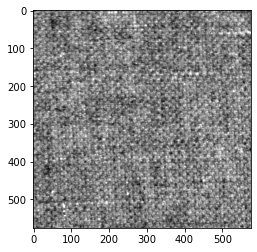

In [120]:
plt.imshow(imgs_gray[0], cmap = plt.cm.gray)
len(imgs_all)

### 3.3. Resizing the images to one size ==> 32x32

In [121]:
######## resize images ###########
imgs_resize = []
for i in imgs_gray:
    imgs_resize.append(skimage.transform.resize(i, (32,32), preserve_range=True))

# 4. Image Matching

This link was used for calculating normalization 

https://anomaly.io/understand-auto-cross-correlation-normalized-shift/index.html

### 4.1.1. Dot product function (to be used in correlation and convolution)

In [125]:
def dot_product(arr1, arr2): ## on condition that 2 arrays are of same length
    multiply = []
    for i in range(len(arr1)):
        for j in range(len(arr1[0])):
            multiply.append(arr1[i][j]*arr2[i][j])
    dot = np.sum(multiply)
    return dot

### 4.1.1. Dot product with normalization function (to be used in correlation and convolution) [[FAILED: Similarity score in negative]

In [12]:
def dot_product_norm(arr1, arr2): ## on condition that 2 arrays are of same length
    multiply = []
    for i in range(len(arr1)):
        for j in range(len(arr1[0])):
#             x = arr1[i][j] - mean(arr1)
            multiply.append((arr1[i][j]- arr1.mean())*(arr2[i][j]- arr2.mean()))
    dot = np.sum(multiply)
    sq = sqrt(np.sum((arr1- arr1.mean())**2)*np.sum((arr2- arr1.mean())**2))
    dot = dot/sq
    return dot

### 4.2. Image Matching function

In [126]:
def matchingImages(imageA, imageB, method = 'cc', normalize = 'n'):
    
    meth = {'cc', 'conv', 'ssd'}
    if method not in meth:
        raise ValueError("Please input one of these values [%r] in the method argument " % meth)
        
    norm = {'y', 'n'}
    if normalize not in norm:
        raise ValueError("Normalize must be one of the following %r." % norm)
        
    if method == 'cc':
        similarity = dot_product(imageA, imageB)
    
    elif method == 'conv':
        imageB_ud = imageB[::-1]   ## Assuming ImageB is a kernel
        imageB_ud_lr = imageB[:, ::-1]
        similarity = dot_product(imageA, imageB_ud_lr)
        
    elif method == 'ssd':
        diff = []
        for i in range(len(imageA)):
            for j in range(len(imageA[0])):
                diff.append((imageA[i][j] - imageB[i][j])**2) ## make power 2 for each element
        similarity= sum(diff)
    
    if normalize == 'y':
        sq = sqrt(np.sum(imageA**2)*np.sum(imageB**2))
        similarity = similarity/sq

    return similarity

In [128]:
matchingImages(imgs_resize[0], imgs_resize[1], 'conv', 'n')

16230050.125

In [131]:
conv_norm = matchingImages(imgs_resize[0], imgs_resize[1], 'conv', 'y')
conv_no_norm = matchingImages(imgs_resize[0], imgs_resize[1], 'conv', 'n')
cc_norm = matchingImages(imgs_resize[0], imgs_resize[1], 'cc', 'y')
cc_no_norm = matchingImages(imgs_resize[0], imgs_resize[1], 'cc', 'n')
ssd_norm = matchingImages(imgs_resize[0], imgs_resize[1], 'ssd', 'y')
ssd_no_norm  = matchingImages(imgs_resize[0], imgs_resize[1], 'ssd', 'n')

print('convolution with normalization: {0:.4f}% while convoltion without normalization is: {1}'.format(conv_norm, conv_no_norm))
print('cross-correlation with normalization: {0:.4f}% while cross-correlation without normalization is: {1}'.format(cc_norm, cc_no_norm))
print('SSD with normalization: {0:.4f}% while SSD without normalization is: {1}'.format(ssd_norm, ssd_no_norm))

convolution with normalization: 0.9924% while convoltion without normalization is: 16230050.125
cross-correlation with normalization: 0.9932% while cross-correlation without normalization is: 16242111.875
SSD with normalization: 0.0137% while SSD without normalization is: 223479.62499999994


### 4.3. Thresholding between the different classes
From before we can notice that the best scores are the normalized ones since they give a good sense by the normalized view; and the most discriminating one is the cross correlation metric where for same textures (image0 and image1 in canavas; cc: 0.993, conv: 0.992, ssd: 0.013) While for different textures (canavas and cushion textures; cc: 0.986, conv: 0.987, ssd: 0.027) which shows that the difference between conv and cc is slightly different and the difference between the same and different textures in ssd is also small.
So, we can choose between cc or ssd but here we choose cc as a good visual metric.

- Apparently, for same textures cc and conv the higher the score the better while for ssd the lower the score the better 

Thus, we shall choose the threshold as: **normalized cross correlation score**

In [134]:
## from 0 --> 29: can1
## from 30 --> 59: cush1
## from 60 --> 89: lin1
## from 90 --> 119: sand1
## from 120 --> 149: seat2
## from 150 --> 179: stone1

Here, different images are matched using the function with normalized cc to get a suitable threshold
We choose '0.985' as a threshold as a discriminator between being from the same class or different 

In [135]:
thresh_canv = matchingImages(imgs_resize[0], imgs_resize[1], 'cc', 'y')
thresh_cush = matchingImages(imgs_resize[30], imgs_resize[31], 'cc', 'y')
thresh_lin1 = matchingImages(imgs_resize[60], imgs_resize[61], 'cc', 'y')
thresh_sand1 = matchingImages(imgs_resize[90], imgs_resize[91], 'cc', 'y')
thresh_seat2 = matchingImages(imgs_resize[120], imgs_resize[121], 'cc', 'y')
thresh_stone1  = matchingImages(imgs_resize[150], imgs_resize[151], 'cc', 'y')

print(thresh_canv)  ##  0.993;;;; 0.9865 => canvas and cushion,, canvas and line1 ==> 0.9837,, canvas and sand1 ==> 0.989,, canvas and seat2 ==> 0.995, canvas and stone1 ==> 0.9849 
print(thresh_cush) ## 0.9805
print(thresh_lin1)  ## 0.9712
print(thresh_sand1) ## 0.985
print(thresh_seat2)  ## 0.9969
print(thresh_stone1)  ## 0.9766

#### We may choose '0.985' as a threshold

0.9931673996585241
0.9805060591546921
0.9712408060078759
0.9858555181080869
0.9969867851995363
0.9766973553719721


### 4.4. Similarity match
In this function, we return the value: 1 or 0 and whether there's a match or mismatch 

In [132]:
def similarity_classifier(ImageA, ImageB):
    
    threshold = 0.985
    score = matchingImages(ImageA, ImageB, 'cc', 'y')
    
    if score >= threshold:
        ## 1: match, 0: mismatch
        match = 1
        return match, True
    else:
        match = 0 
        return match, False
#     return match

### 4.5. True labels
To calculate the accuracy of the threshold

In [133]:
def true_labels(i, j, y):  #### i, j are indices ;;; y is the true labels
    
    if y[i] == y[j]:
        label = 1
    else:
        label = 0 
        
#     print('true_label: ', label )
    return label

In [16]:
len(imgs_resize)

180

### 4.6. Calculate the similarity and accuracy of the threshold over some pair of images as validation set

We have 180 images so we will take 20% from them and calculate for each image we'll calculate its similarity with all other images chosen and then calculate the accuracy of this
Thus, we will choose 36 images randomly from the list of images

In [136]:
random.seed(1000)
idx = list(range(0, 180))
# idx_rand1 = np.random.choice(idx, size=5, replace = False) 
idx_rand = random.sample(idx, 36)  ### This maintains to be the same each time


The validation set doesn't have to be balanced, however, the train set should be 

In [137]:
predictions = []
correct = []
for i in idx_rand:
    for j in idx_rand:
#         print('i: ', i, ',, j: ', j)
        pred, _ = similarity_classifier(imgs_resize[i], imgs_resize[j])
        predictions.append(pred)
        correct.append(true_labels(i, j, y))
#         print(100*'#')

In [138]:
accuracy = 0
for i in range(len(correct)):
    if predictions[i] == correct[i]:
        accuracy+=1
        
acc_score = accuracy/len(correct)
print(accuracy, len(correct), acc_score) ## how many were classified correctly by this threshold ==> 0.433 

590 1296 0.45524691358024694


The accuracy is **0.455** which shows this threshold is performing less than a random classifier

# 5. MLP

### 5.1. Concatenating the images

In [139]:
idx_train = set(idx) - set(idx_rand)

In [140]:
idx_train = list(idx_train)
len(idx_train)

144

In [141]:
### should we use all the images except the validation ones or what ??
x_train = []
y_train = []
for i in idx_train:
    for j in idx_train:
        concat = np.dstack((imgs_resize[i],imgs_resize[j]))
        x_train.append(concat.flatten())
        y_train.append(true_labels(i, j, y))
        
x_train = np.array(x_train)
y_train = np.array(y_train)

In [142]:
## we can also check the number of 1s and 0s in y to drop some of the 0s (mismatch)
print(x_train.shape, y_train.shape)

(20736, 2048) (20736,)


In [143]:
np.unique(y_train)

array([0, 1])

### 5.2. Rebalancing the data (Undersample)

In [144]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
x_train_under, y_train_under = undersample.fit_resample(x_train, y_train)

In [145]:
## we can also check the number of 1s and 0s in y to drop some of the 0s (mismatch)
print(np.array(x_train_under).shape, np.array(y_train_under).shape)

(6992, 2048) (6992,)


Rebalancing the data takes a lot of time

### 5.2. MLP classifier

#### Resampled data

In [146]:
clf = MLPClassifier(random_state=2, max_iter=500).fit(x_train_under, y_train_under)

# 6. Comparison

In [147]:
x_valid = []
y_valid = []
for i in idx_rand:
    for j in idx_rand:
        concat = np.dstack((imgs_resize[i],imgs_resize[j]))
        x_valid.append(concat.flatten())
        y_valid.append(true_labels(i, j, y))


In [148]:
y_pred = clf.predict(x_valid)
acc = accuracy_score(y_valid, y_pred)

In [149]:
print('Accuracy of rebalanced data is: {0:.2f}%,'.format(acc )) # we can see here how the accuracy is much more higher than random classifier or thresholding

Accuracy of rebalanced data is: 0.55%,


In [150]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.60      0.68      1040
           1       0.19      0.38      0.25       256

    accuracy                           0.55      1296
   macro avg       0.49      0.49      0.47      1296
weighted avg       0.68      0.55      0.60      1296



- Here we compare between the resampled and original data; Apparently accuracy isn't the best metric for imbalanced data. As in the original data it gives 80% accuracy where they're the true classifications of the major class. However, the recall/precision and all metrics of the other class equal zero. 
- However, if we look at the resampled data: the accuracy here is higher than the threshold classifier: 55% and the values are distributed among the different classes, which is reasonable

==> In MLP, the **training effort** is higher due to training the classifier, the **prediction speed** is comparable or even slower due to using the classifier not just if condition. However, the **performance** and **generalization** in MLP are much better in MLP and it seems that with some fine tuning it may work even better.

# 7. Feature Engineering

In [151]:
###### gaussian ########## 
img_g = skfl.gaussian(imgs_resize[0], sigma = 0.7)

In [152]:
######### DoG ############
img_dog = skfl.difference_of_gaussians(img_g, low_sigma = 0.2)

In [153]:
########## sobel ############
img_sobel = skfl.sobel(img_dog)

In [154]:
########### gabor #############
img_gabor_real, img_gabor_img = skfl.gabor(img_sobel, 1)

180

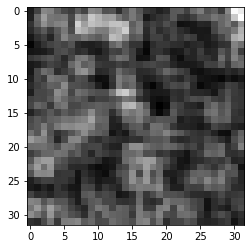

In [155]:
plt.imshow(img_gabor_real, cmap = plt.cm.gray)
len(imgs_all)

In [156]:
def pipe_filters(img):
    img_f = img
    img_f = skfl.gaussian(img, sigma = 0.7)
    img_f = skfl.difference_of_gaussians(img_f, low_sigma = 0.2)
    img_f = skfl.sobel(img_f)
#     img_f = skfl.hessian(img_f)
    img_f, img_f_img = skfl.gabor(img_f, 1)
    
    return img_f

To reduce the features into 32 or less, we can use PCA for dimentionality reduction or resize the image into 5x5 where the flattened array will be equal to 25 features.
The method used here is PCA.

In [157]:
imgs_filtered = []
for i in imgs_resize:
    imgs_filtered.append(pipe_filters(i))

In [158]:
x_train_f = []
y_train = []
for i in idx_train:
    for j in idx_train:
        concat = np.dstack((imgs_filtered[i],imgs_filtered[j]))
        x_train_f.append(concat.flatten())
        y_train.append(true_labels(i, j, y))
        
x_train_f = np.array(x_train_f)
y_train_f = np.array(y_train)

In [159]:
print(x_train_f.shape, y_train_f.shape)

(20736, 2048) (20736,)


#### Undersampling

In [160]:
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
x_trainf_under, y_trainf_under = undersample.fit_resample(x_train_f, y_train_f)

In [161]:
print(x_trainf_under.shape, y_trainf_under.shape)

(6992, 2048) (6992,)


#### Dimensionality reduction

In [162]:
pca = PCA(n_components=32)
x_train_pca = pca.fit_transform(x_trainf_under)

In [163]:
print(x_train_pca.shape, y_trainf_under.shape)

(6992, 32) (6992,)


#### Classifier

In [164]:
clf3 = MLPClassifier(random_state=1, max_iter=300).fit(x_train_pca, y_trainf_under)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [165]:
x_valid_f = []
y_valid_f = []
for i in idx_rand:
    for j in idx_rand:
        concat = np.dstack((imgs_filtered[i],imgs_filtered[j]))
        x_valid_f.append(concat.flatten())
        y_valid_f.append(true_labels(i, j, y))

In [166]:
x_valid_f = pca.fit_transform(x_valid_f)
y_pred_f = clf3.predict(x_valid_f)
acc = accuracy_score(y_valid_f, y_pred_f)  #### the accuracy increased from 0.80 to 0.86 
print(acc)

0.6265432098765432


In [167]:
print(classification_report(y_valid_f, y_pred_f))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1040
           1       0.18      0.25      0.21       256

    accuracy                           0.63      1296
   macro avg       0.49      0.49      0.48      1296
weighted avg       0.67      0.63      0.65      1296



#### Insights:
**0. No filters ==> 0.55**

**1. Gaussian(0.7), DoG(0.2), Sobel, Gabor(1) ==> 0.655 validation**

-- These filters make a pipeline that firstly smoothes the image to remove any outliers or noise, then apply difference of gaussian to get the edges while smoothing, afterwards sobel *(which is the main contributor in the enhancement)* is used as a perfect edge detector where in these images there are alot of **intensity changes across pixels (edges)** that are different for different classes thus egde detection is needed, Finally Gabor filter is used

## Testing data

### Loading and labelling

In [168]:
dict_img_test = {}
for root, _, files in os.walk("textures\\testing", topdown=False):
#     print(root[17:])
    dict_img_test[root[17:]] = np.array([root+ '\\' + i for i in files])

In [169]:
canvas1 = dict_img_test.get('canvas1')
cushion1 = dict_img_test.get('cushion1')
linsseeds1 = dict_img_test.get('linsseeds1')
sand1 = dict_img_test.get('sand1')
seat2 = dict_img_test.get('seat2')
stone1 = dict_img_test.get('stone1')

In [170]:
args = (canvas1, cushion1, linsseeds1, sand1, seat2, stone1)
all_arr_test = np.concatenate(args)

In [171]:
y_test = np.zeros(len(all_arr_test))
y_test[0:10] = 0 
y_test[10:20] = 1
y_test[20:30] = 2
y_test[30:40] = 3
y_test[40:50] = 4
y_test[50:60] = 5

In [172]:
print(all_arr_test[10])

textures\testing\cushion1\cushion1-a-p031.png


### Read, resize and gray

In [173]:
imgs_all_test = []
for i in all_arr_test:
    x = io.imread(i)
    y = skimage.color.rgb2gray(x)
    imgs_all_test.append(skimage.transform.resize(y, (32,32), preserve_range=True))

<ipython-input-173-59aaf82928ad>:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  y = skimage.color.rgb2gray(x)


### Concatenating and filtering (2 datasets: one with filter and one without) 

In [174]:
lbl_test_f = []
x_test_f = []
test_filter = []
lbl_test = []
x_test = []

for i in range(len(y_test)):
    test_filter.append(pipe_filters(imgs_all_test[i]))
    
for i in range(len(y_test)):
    for j in range(len(y_test)):
        concat_test_f = np.dstack((test_filter[i],test_filter[j]))
        x_test_f.append(concat_test_f.flatten())
        lbl_test_f.append(true_labels(i, j, y_test))

for i in range(len(y_test)):
    for j in range(len(y_test)):
        concat_test = np.dstack((imgs_all_test[i],imgs_all_test[j]))
        x_test.append(concat_test.flatten())
        lbl_test.append(true_labels(i, j, y_test))

In [175]:
print(np.array(x_test).shape, np.array(lbl_test).shape)
print(np.array(x_test_f).shape, np.array(lbl_test_f).shape)

(3600, 2048) (3600,)
(3600, 2048) (3600,)


### Resampling and dimensionalty reduction (filtered test data)

In [176]:
######### filtered test data ###########

under_f = NearMiss(version=1, n_neighbors=3)
# transform the dataset
x_testf_under, y_testf_under = under_f.fit_resample(x_test_f, lbl_test_f)

pca_f = PCA(n_components=32)
x_test_f_pca = pca.fit_transform(x_testf_under)

### Resampling and dimensionalty reduction (UN-filtered test data)

In [177]:
######### normal test data ###########

under = NearMiss(version=1, n_neighbors=3)
# transform the dataset
x_test_under, y_test_under = under.fit_resample(x_test, lbl_test)

pca_test = PCA(n_components=32)
x_test_pca = pca.fit_transform(x_test_under)

### Prediction using the classifier (filtered data)

In [178]:
################### filtered test prediction ##############

y_pred_f_test = clf3.predict(x_test_f_pca)
acc = accuracy_score(y_testf_under, y_pred_f_test)  
print(acc)
print(classification_report(y_testf_under, y_pred_f_test))

0.8416666666666667
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       600
           1       0.82      0.87      0.85       600

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



### Prediction using the classifier (UN- filtered data)

In [179]:
################### original test prediction ##############

y_pred_test = clf3.predict(x_test_pca)
acc = accuracy_score(y_test_under, y_pred_test)  
print(acc)
print(classification_report(y_test_under, y_pred_test))

0.5641666666666667
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       600
           1       0.56      0.61      0.58       600

    accuracy                           0.56      1200
   macro avg       0.56      0.56      0.56      1200
weighted avg       0.56      0.56      0.56      1200



- Apparently, on the test case by the same pipeline: we can see that the test data with filtering yields much higher accuracies than data without filtering. And here accuracy is a valid parameter since we rebalanced the data. 
- Also we can see from the classification report that the performance on the two classes using the filtered test data is much higher than without filtering